In [114]:
import numpy as np, pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [115]:
train = pd.read_csv('train_cutted.csv')
test = pd.read_csv('test_cutted.csv')

In [117]:
from sklearn.model_selection import train_test_split

#### 留出30%训练数据用来评估模型

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    train.iloc[:,:-1], train['target'], test_size=0.3, random_state=42)

# 再次处理不平衡
<pre>
直接下采样有点暴殄天物，因为这个数据集的量比较小
所以对正样本多次采样和负样本拼接组成多个训练集，最终的fit的数据由他们求均值得到（有点投票的意思）

（在后面观察几个训练集训练结果，发现他们生成的学习器效果都很接近，这也是我们想要的结果）
</pre>

#### 下采样+拼接

In [120]:
def undersample(X, y, subsets=7):
    data = X.join(y)
    train_sets = []
    neg = data[data['target']==0]
    pos = data[data['target']==1]
    for i in range(subsets):
        re_neg = neg.sample(frac=0.5)
        combine = pd.concat([re_neg, pos])
        train_sets.append(combine)
    return train_sets

In [121]:
train_sets = undersample(X_train, y_train, subsets=7)

#### 定义训练函数
<pre>
对多个训练集学习，收集他们的系数、预测概率
之前我通过手动遍历C值得到C=2时比较适合这些数据集
</pre>

In [143]:
def training(data_sets, test):
    test_results = []
    coefs = []
    intercepts = []
    model = LogisticRegression(C=2)
    
    for data in data_sets:
        y_train = data['target']
        x_train = data.iloc[:,:-1]
        clf = model.fit(x_train.values, y_train.values)
        coefs.append(clf.coef_)
        intercepts.append(clf.intercept_)
        test_results.append(clf.predict_proba(test)[:,1])

    return {'test_results':test_results, 'coefs':coefs, 'intercepts':intercepts}

# 这里画不了学习曲线，在开始采样时正样本比例过低，会报错

# 先对70%的训练集学习

In [137]:
test_result = training(train_sets, X_test)

In [138]:
results = DataFrame(test_result['test_results']).mean()

In [126]:
from sklearn.metrics import roc_curve, auc

In [139]:
fpr, tpr, thresholds = roc_curve(y_test.values, results.values)

#### auc=0.88

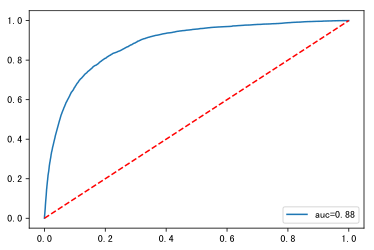

In [252]:
plt.grid()
plt.plot(fpr, tpr, label='auc=%.2f'%auc(fpr,tpr))
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc='lower right')

#### ks=0.61

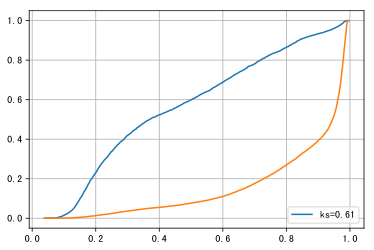

In [251]:
plt.grid()
plt.plot(1-thresholds, tpr, label='ks=%.2f'% max(tpr-fpr))
plt.plot(1-thresholds, fpr)
plt.legend(loc='lower right')

# 把所有train数据放进去计算
<pre>
并获得系数和截距
</pre>

In [130]:
train_sets = undersample(train.iloc[:,:-1], train['target'], subsets=7)

In [146]:
training_result = training(train_sets, test.iloc[:, :-1])

In [ ]:
#coefs = training_result

In [201]:
intercept = DataFrame(training_result['intercepts']).mean()[0]

In [198]:
coefs = DataFrame(np.array(training_result['coefs'])[:,0,:]).mean()

# 评分

<pre>
客户是坏客户概率除以是好客户概率比：odd=p/(1-p)
我们把评分和ln(odd)做线性拟合
一方面当odd越大，是坏客户几率越大
另一方面ln(p/(1-p))就是LR模型的θ.T*x，可以直接获得
</pre>
\begin{align}
ln(\frac{p}{1-p})=\theta^Tx
\end{align}
<pre>
假设odd为1/20时的分数是600分
odd升到1/10时分数下降30分
就可以求出线性方程的斜率和截距a、b
</pre>
\begin{align*}
600 &= A-Bln(1/20) \\
600-30 &= A-Bln(2/20)
\end{align*}

In [214]:
odd = 1/20
b = 30/np.log(2)
a = 600 + b*np.log(odd)

<pre>
最后就可以这样获得各个用户的分数了：
</pre>
\begin{align}
score&=A-B*β_0-B*β_1*w_1-···-B*β_n*w_n
\end{align}

In [202]:
intercept

-1.0793045763668219

In [200]:
coefs

0   -0.783247
1   -0.382026
2   -0.720417
3   -0.182033
4   -0.543901
5   -0.603020
dtype: float64

In [204]:
score = \
a-b*intercept-\
-0.783247*b*test['RuOfUL'] -\
-0.382026*b*test['age'] -\
-0.720417*b*test['30-59DaysPastDue'] -\
-0.182033*b*test['DebtRatio'] -\
-0.543901*b*test['MIncome'] -\
-0.603020*b*test['Dependents']

<pre>
从直方图来看，好像用户分三个群体
550+        优质客户
450-550     普通用户
450以下     准老赖用户
</pre>

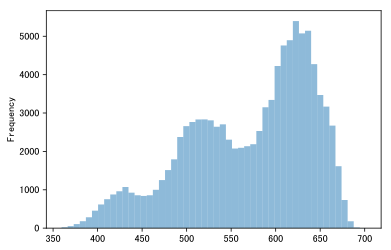

In [259]:
score.plot.hist(alpha=0.5,bins=50)

In [ ]:
plt.show()

# 后续
<pre>
后面还有很多工作要做
包括模型的和分数的调整
</pre>